**Introduction and Motivation**  -- What were you trying to do  and WHY?
  - For full points clearly state the problem and why it is important. (approx 2 points)

**Related work**
- Mention any related work from our class readings or from other literature.
This can be something as general as discussing generalization/overfitting or whether you are using parametric or non-parametric methods …. (You do not have to use the methods taught in class. You do not have to do unsupervised learning).

- For full credit also mention a paper in the literature that addresses this problem
(or if there is nothing like it in the literature make the case for why your problem is unique). (approx 2 points)  


**Methods**
- What did you do?  Be as precise as you can.   For full credit there should be enough detail for someone relatively skilled to replicate your work.  (approx 7 points)

Batteries 49, 50, 51, 52 experiments ended early, can use data from other batteries to predict their EOL


Predict remaining charge capacity for a given discharge cycle

Predict remaining useful life

Potentially:
- Group data points on a temperature vs remaining charge capacity graph
- Clustering on a cycle vs charge capacity graph (different clustering algorithms here)

**Results**
- What did you discover? How well did it work?  As this is a class project, it is likely that many things did not work as well as planned.  For this project, detailing what went wrong is as important as describing what went well.  (approx 7 points)

**Discussion**
- What did you learn?  What could you do better? (What would you
have done next if you had more time)?.....  Why do you think it didn't work if it didn't?  

- If everything worked perfectly,  what next steps would you suggest for follow-up work.  For full credit discuss two extensions or improvements to your project with short justifications for why you think that would work better (improvements) or why they are promising extensions. (approx 7 points) 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('./cleaned_dataset/metadata.csv')

               Capacity
0    1.6743047446975208
4    1.5243662105099023
6    1.5080762969973425
8    1.4835577960067696
10   1.4671391666146525
..                  ...
172  1.2031062978889062
174  1.1897147112197684
176   1.177422568842014
178   1.158443027293818
180  1.1567087516841796

[72 rows x 1 columns]
0      1.6743047446975208
4      1.5243662105099023
6      1.5080762969973425
8      1.4835577960067696
10     1.4671391666146525
              ...        
172    1.2031062978889062
174    1.1897147112197684
176     1.177422568842014
178     1.158443027293818
180    1.1567087516841796
Name: Capacity, Length: 72, dtype: object


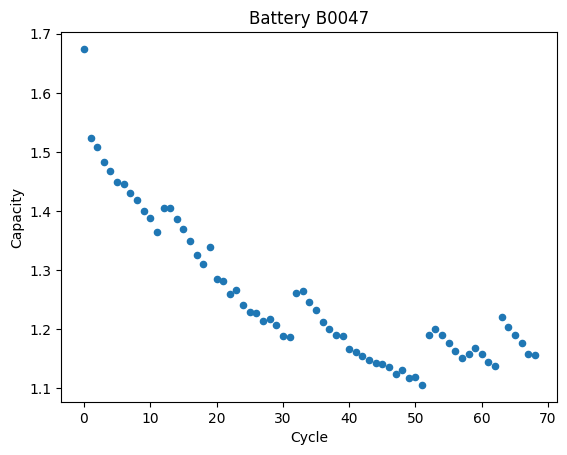

               Capacity
184  1.0819793880779518
188   0.927952404748273
190   0.885193608411576
192  0.8581010699478283
194  0.8409352213456689
..                  ...
356  0.6495813516716594
358  0.6337485177966306
360  0.6298550929085645
362  0.6183063778386736
364  0.6069476168507777

[72 rows x 1 columns]
184    1.0819793880779518
188     0.927952404748273
190     0.885193608411576
192    0.8581010699478283
194    0.8409352213456689
              ...        
356    0.6495813516716594
358    0.6337485177966306
360    0.6298550929085645
362    0.6183063778386736
364    0.6069476168507777
Name: Capacity, Length: 72, dtype: object


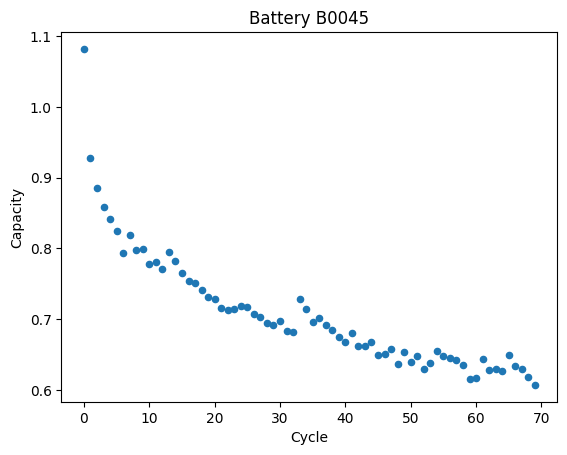

               Capacity
368  1.6579955793677608
372  1.5076933476098775
374  1.4989223343608031
376  1.4782919502497789
378   1.461856891390611
..                  ...
540  1.2691220651743778
542  1.2555144634690785
544  1.2519876926897657
546  1.2374982003019996
548  1.2231273969878986

[72 rows x 1 columns]
368    1.6579955793677608
372    1.5076933476098775
374    1.4989223343608031
376    1.4782919502497789
378     1.461856891390611
              ...        
540    1.2691220651743778
542    1.2555144634690785
544    1.2519876926897657
546    1.2374982003019996
548    1.2231273969878986
Name: Capacity, Length: 72, dtype: object


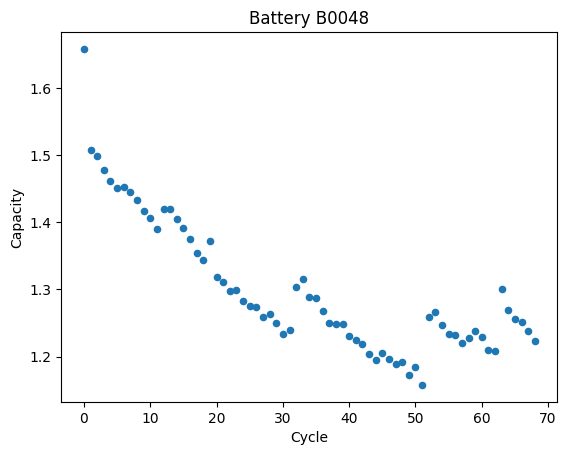

               Capacity
552  1.7282392323598248
556  1.5161488467923143
558   1.503121190703977
560    1.48586566102824
562  1.4694562316392716
..                  ...
724  1.2050453590356518
726    1.19119860196273
728    1.17463817374538
730  1.1555432048235512
732  1.1538041170229467

[72 rows x 1 columns]
552    1.7282392323598248
556    1.5161488467923143
558     1.503121190703977
560      1.48586566102824
562    1.4694562316392716
              ...        
724    1.2050453590356518
726      1.19119860196273
728      1.17463817374538
730    1.1555432048235512
732    1.1538041170229467
Name: Capacity, Length: 72, dtype: object


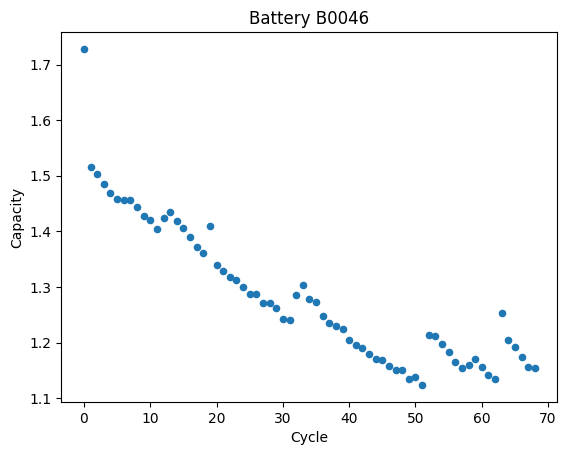

                Capacity
738    1.713782642126885
740   1.6955681658647108
742   1.6814906372051954
744   1.6786372409532953
746   1.6694168550864992
...                  ...
999   1.3257206687421472
1003  1.3142909715978441
1005  1.3003260094811093
1007  1.2881071401556836
1009  1.2767801501201566

[112 rows x 1 columns]
738      1.713782642126885
740     1.6955681658647108
742     1.6814906372051954
744     1.6786372409532953
746     1.6694168550864992
               ...        
999     1.3257206687421472
1003    1.3142909715978441
1005    1.3003260094811093
1007    1.2881071401556836
1009    1.2767801501201566
Name: Capacity, Length: 112, dtype: object


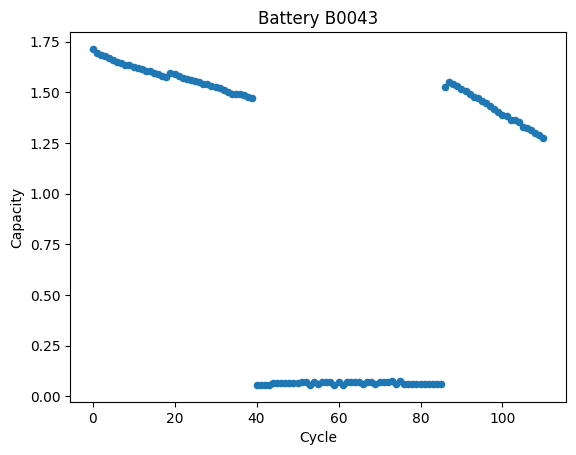

                Capacity
1012  1.7048641073512139
1014  1.8940319526948572
1016  1.8747686491853095
1018  1.8654947184112376
1020  1.8527398169018068
1024   1.844174397003866
1026  1.8430238477512753
1028  1.8302818174911863
1030  1.8173838456081814
1032  1.8057992981104682
1036  1.8149829605049186
1038  1.7995150369321797
1040  1.7866516942518147
1042  1.7735550719416031
1044   1.769995333364443
1048   1.799526080374287
1050  1.7968530684449833
1052  1.7838265504081745
1054  1.7696444491040102
1056  1.7512940457049684
1060  1.7697554297961993
1062  1.7547726933914918
1064  1.7389166355812984
1066  1.7337200518764075
1068  1.7150972597500092
1072  1.7462926148815636
1074   1.719149261914565
1076   1.711582246191498
1078  1.6951051195225901
1080  1.7005124371100973
1084  1.7080989351250158
1086   1.691435430587127
1088  1.6844494328889932
1090   1.664037581688075
1092  1.6686372014231974
1096  1.6899344075625968
1098   1.669431712846442
1100  1.6634226761839213
1102  1.6436152195947373


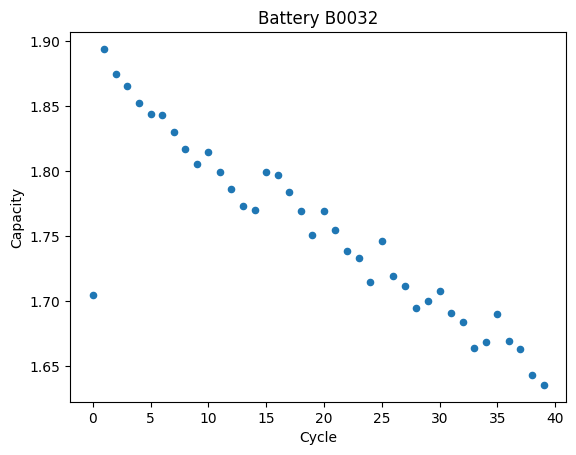

                 Capacity
1108  0.11903831859341765
1112   0.4729861500927512
1114  0.16280793829202067
1116   0.4787632853388766
1118   0.4711383364607152
1120   0.4668172561120673
1124   0.4699932676625547
1128   0.4627052684317185
1130  0.46049447826560974
1132   0.4412227248835694
1134  0.44354421943965844
1136   0.4126655541164234
1140   1.7461791006389626
1144   1.7695250734505363
1146   1.7715391419501945
1148    1.770625483958279
1150   1.7704040639447296
1152   1.7695081788801759
1156   1.7638356274269416
1160   1.7715725869786123
1162   1.7701196454489683
1164   1.7667569752860521
1166   1.7648743629092642
1168    1.763838685943225
1172   1.7657225752056789
1174   1.7645632809383045
1176   1.7608991948479125
1178   1.7598362095817717
1180   1.7590955400143164
1184   1.7560495443976523
1186   1.7571677199949287
1188   1.7558911269459976
1190   1.7533419072229914
1192   1.7506673845335168
1196   1.7510006664162403
1198   1.7496058853847873
1200   1.7477359172183355
1202   1.744

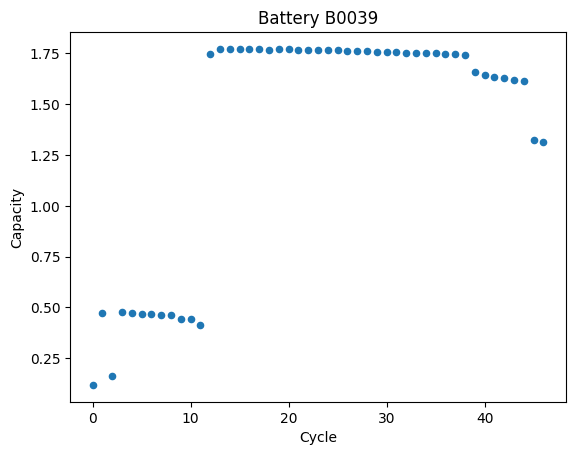

                Capacity
1230  0.6734628137095633
1234  0.7913062105760345
1236  0.7865824034601745
1238  0.7795871426061582
1240  0.7628241523125163
1242  0.7405021514606399
1246  0.7783970881100656
1250  0.7733165409025605
1252  0.7589575236409498
1254  0.7407399462256391
1256  0.7446218752617147
1258  0.7149875629820736
1262  1.7075144448533202
1266   1.730880859428193
1268  1.7328212845233328
1270  1.7317734323431513
1272  1.7341296392350067
1274  1.7334756929990074
1278  1.7243057179457875
1282  1.7318975861687205
1284  1.7333691208377457
1286   1.732175650153278
1288  1.7334832776102866
1290   1.732372495746513
1294  1.7338175297202416
1296  1.7329630786357868
1298  1.7318839084573339
1300  1.7306960059812662
1302  1.7296011601947467
1306  1.7296187381064656
1308  1.7307198617163877
1310   1.729274556175907
1312  1.7297962212599596
1314  1.7268942069037494
1318  1.7272191689306016
1320  1.7285674981160106
1322   1.726636381605547
1324  1.7262424141835067
1326  1.7252725927602899


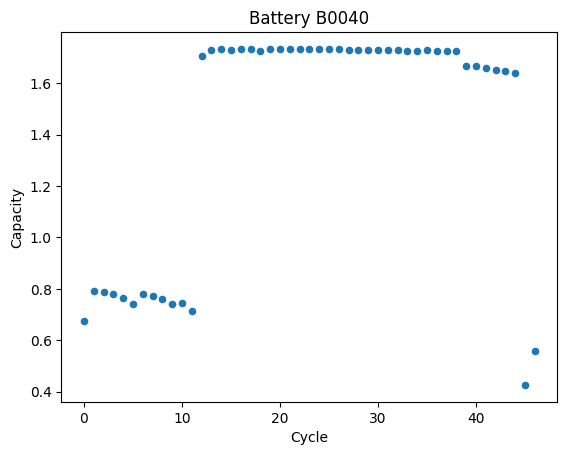

                Capacity
1353   1.697507332205763
1355   1.844701206961174
1357  1.8254376674722927
1359   1.815750429913437
1361  1.8132993337127028
1365  1.8151647619660576
1367  1.8143317955190057
1369   1.801343601809866
1371  1.7881558802945825
1373  1.7760714604539518
1377  1.7852807447597443
1379  1.7698116401111978
1381  1.7565231680521758
1383  1.7543413277348154
1385  1.7392875506998715
1389  1.7797845109331345
1391  1.7657088508465202
1393  1.7523941408724169
1395  1.7380191225603105
1397  1.7312214443143976
1401  1.7379128985265808
1403  1.7224270683625882
1405  1.7184213765608034
1407  1.7010220930648232
1409   1.693698739563104
1413   1.713072721286705
1415  1.6976972688567131
1417  1.6899314034061208
1419   1.685023551367069
1421   1.678389965463405
1425  1.6737947494868326
1427  1.6687898927884715
1429  1.6492566306631427
1431  1.6409676757039668
1433  1.6456360229757092
1437   1.654547743574037
1439  1.6461201520877546
1441  1.6275119188151763
1443  1.6200530533464497


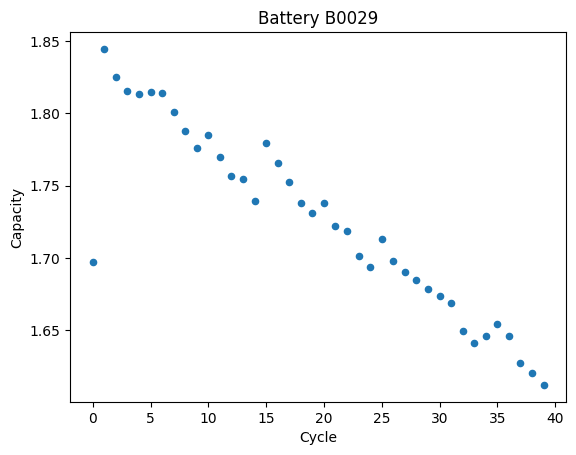

                Capacity
1452  1.8046847720100736
1454  1.8047833214525881
1456   1.797618668222458
1458  1.7929913687761174
1460  1.7919180081592216
1464   1.775026135903797
1468  1.7920487852223415
1471   1.790475801581265
1473  1.7868365091987264
1475  1.7871529619962185
1479  1.7816340617009505
1483  1.7850235136604733
1485  1.7803865429693038
1487  1.7789060856417256
1489  1.7738387518973049
1491   1.769682881523146
1495  1.7408787283206992
1499  1.7648189744011906
1501  1.7617857390844023
1503    1.75770610357021
1505  1.7519375960601256
1507  1.7521244035832177
1514  1.7597714133989641
1516  1.7483011320324189
1518  1.7411482627836237
1520  1.7363833316311177
1522   1.736559066269527
1526  1.7172335652295245
1452    1.8046847720100736
1454    1.8047833214525881
1456     1.797618668222458
1458    1.7929913687761174
1460    1.7919180081592216
1464     1.775026135903797
1468    1.7920487852223415
1471     1.790475801581265
1473    1.7868365091987264
1475    1.7871529619962185
1479 

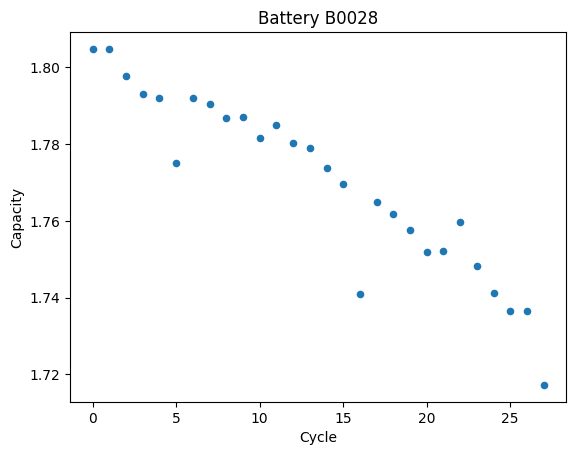

                Capacity
1531  1.7287126633755356
1533  1.7314706281853145
1535  1.7282350363146088
1537   1.720344742291621
1539  1.7221734367707637
...                  ...
1792  1.3752493030002435
1796  1.3671966130854505
1798   1.356887600783644
1800  1.3449320225969348
1802  1.3374691704584258

[112 rows x 1 columns]
1531    1.7287126633755356
1533    1.7314706281853145
1535    1.7282350363146088
1537     1.720344742291621
1539    1.7221734367707637
               ...        
1792    1.3752493030002435
1796    1.3671966130854505
1798     1.356887600783644
1800    1.3449320225969348
1802    1.3374691704584258
Name: Capacity, Length: 112, dtype: object


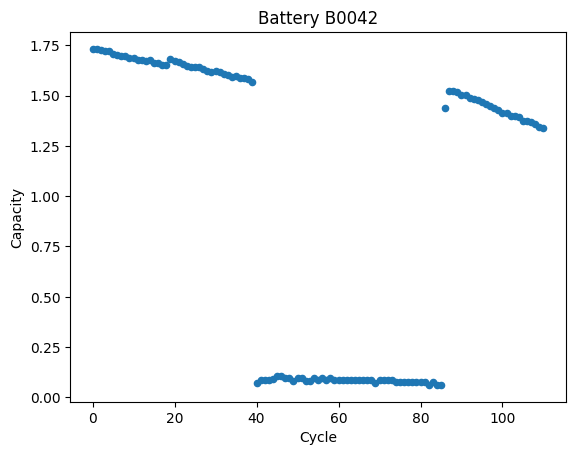

                Capacity
1804  0.7459302957645664
1808  1.6623217152845853
1810   1.645087369694532
1812   1.620729289277574
1814  1.5967402025126005
...                  ...
2278    1.34598253292492
2280  1.3286875315413778
2282    1.31203071983408
2284   1.295125492961198
2286  1.2802601605963335

[197 rows x 1 columns]
1804    0.7459302957645664
1808    1.6623217152845853
1810     1.645087369694532
1812     1.620729289277574
1814    1.5967402025126005
               ...        
2278      1.34598253292492
2280    1.3286875315413778
2282      1.31203071983408
2284     1.295125492961198
2286    1.2802601605963335
Name: Capacity, Length: 197, dtype: object


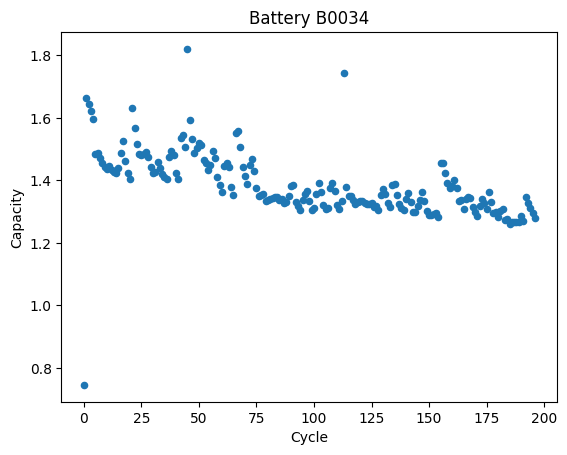

                Capacity
2290  0.8980573709676724
2294  1.1026236331914077
2296  1.0885801879473431
2298  1.0613249847591086
2300  1.0347062057983545
2302  1.0269978594353013
2306  1.0785019710989419
2310  1.0638897478802845
2312  1.0366551223324423
2314   1.030941327482094
2316  1.0140084541034655
2318   1.008516095994519
2322  1.7419245088095903
2326   1.779741859708433
2328  1.7815666306452766
2330  1.7834859577156017
2332  1.7864411650415675
2334  1.7859997608067948
2338  1.7769523773001608
2342   1.781428917321899
2344  1.7859452772697197
2346   1.785208429691551
2348   1.783596609584544
2350  1.7796783152744713
2354  1.7841102592788645
2356  1.7833032331592193
2358  1.7796186141356956
2360  1.7816592334352586
2362  1.7775911304124035
2366   1.777701881971679
2368  1.7789547618270618
2370  1.7807753731135043
2372   1.778415319026661
2374  1.7789773899108463
2378  1.7792479347236045
2380  1.7779204573685081
2382   1.779227040224144
2384  1.7760634320079352
2386   1.775103937963957


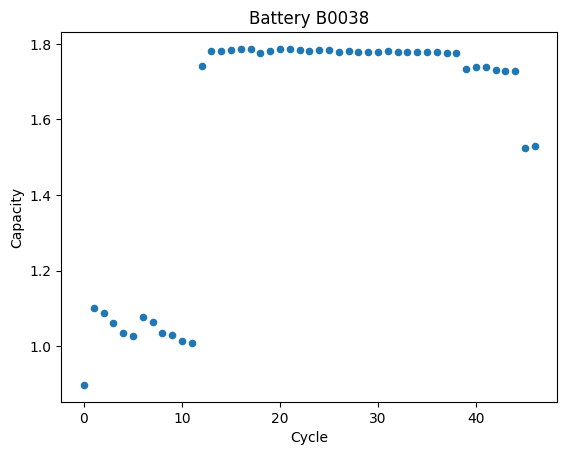

                 Capacity
2412  0.06842572240601812
2416   0.6895699007862814
2418   1.1610848192311252
2420   1.2529393053824995
2422    1.302918002447558
...                   ...
2886   1.3280324770208678
2888   1.3634549770713926
2890   1.3291316747402466
2892   1.3124201086917682
2894   1.3152825503676357

[197 rows x 1 columns]
2412    0.06842572240601812
2416     0.6895699007862814
2418     1.1610848192311252
2420     1.2529393053824995
2422      1.302918002447558
               ...         
2886     1.3280324770208678
2888     1.3634549770713926
2890     1.3291316747402466
2892     1.3124201086917682
2894     1.3152825503676357
Name: Capacity, Length: 197, dtype: object


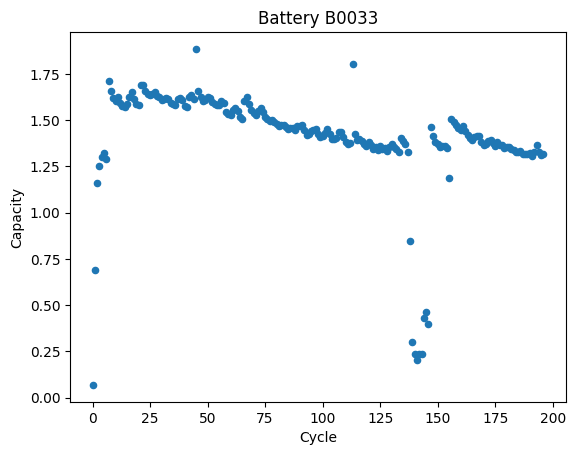

                Capacity
2899  1.6560706096175404
2901  1.7815548749509116
2903   1.761969227822918
2905   1.751755031874225
2907  1.7381688070362076
2911  1.7506745293461339
2913  1.7491047649061158
2915  1.7252544028765475
2917  1.7112621367644252
2919  1.6990418392711273
2923  1.7185770039532977
2925    1.70324722921867
2927   1.689458044662304
2929  1.6756136292719177
2931  1.6718407140871654
2935  1.7233056681204446
2937   1.709207290507283
2939   1.684001734344571
2941    1.66898698813004
2943  1.6620689362837142
2947  1.6687049625248174
2949   1.652762183550463
2951   1.648481366235244
2953  1.6307406443132095
2955    1.62323023017929
2959  1.6541906540394393
2961   1.638514396616985
2963   1.618847673357618
2965  1.6134212267751404
2967  1.6066443601761986
2971  1.6138387876938998
2973   1.596329501327274
2975  1.5890785867406987
2977  1.5805481432309574
2979  1.5846131054270807
2983  1.5936651221220735
2985  1.5849874126960888
2987  1.5787064969416462
2989   1.570705516096967


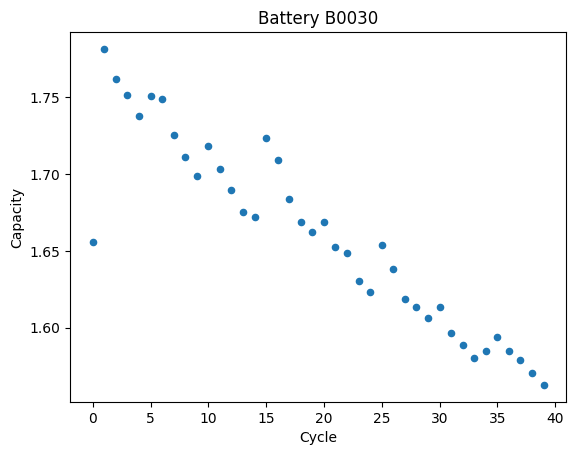

                  Capacity
2995  0.055620243768194036
2998   0.05569747261227687
3000   0.05583901629185397
3002     0.056148059974053
3004   0.05647053159913906
...                    ...
3146    0.8682347537115443
3150    0.8443569490395516
3152    0.8657093203148538
3154     0.848696904019178
3156    0.8364948433646345

[67 rows x 1 columns]
2995    0.055620243768194036
2998     0.05569747261227687
3000     0.05583901629185397
3002       0.056148059974053
3004     0.05647053159913906
                ...         
3146      0.8682347537115443
3150      0.8443569490395516
3152      0.8657093203148538
3154       0.848696904019178
3156      0.8364948433646345
Name: Capacity, Length: 67, dtype: object


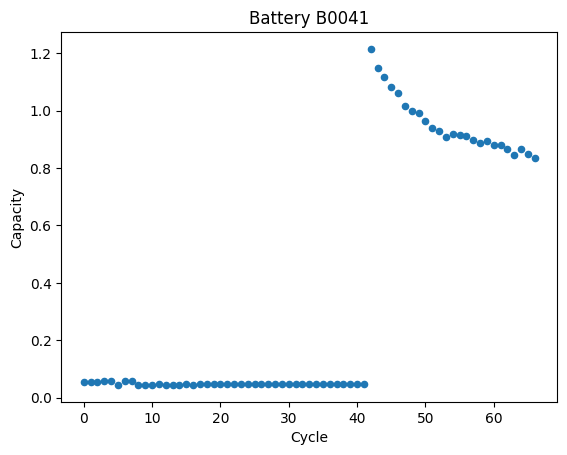

                Capacity
3161  1.8233077742149364
3163  1.8142384651167962
3165  1.8128596793130867
3167  1.8144242446739973
3169   1.812800333853042
3173  1.7946038703195293
3177   1.816519171293833
3180  1.8198335565190242
3182   1.816980986440728
3184  1.8047602710768988
3188  1.8021778881408677
3192   1.810054375611175
3194  1.8191618703574552
3196   1.806344581230731
3198  1.8120006378747944
3200   1.809238569578753
3204  1.7820717716005336
3208  1.8145504562341046
3210   1.809153485164282
3212  1.8065551508093707
3214   1.802401655959492
3216  1.7964331683322998
3223  1.8088036930508289
3225  1.7915527748749653
3227  1.7853375192239571
3229   1.793209210325309
3231  1.7873097711102113
3235  1.7700926253324452
3161    1.8233077742149364
3163    1.8142384651167962
3165    1.8128596793130867
3167    1.8144242446739973
3169     1.812800333853042
3173    1.7946038703195293
3177     1.816519171293833
3180    1.8198335565190242
3182     1.816980986440728
3184    1.8047602710768988
3188 

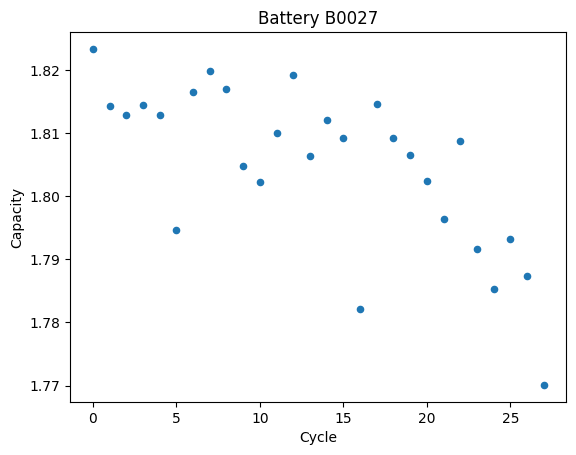

                Capacity
3240   1.686525555152074
3242  1.6624606531639186
3244  1.6534010755700512
3246  1.6452145903490936
3248   1.635664062367341
...                  ...
3501  1.2906172590904164
3505  1.2752011253442166
3507  1.2686072657374579
3509  1.2565759973225976
3511  1.2486254509320867

[112 rows x 1 columns]
3240     1.686525555152074
3242    1.6624606531639186
3244    1.6534010755700512
3246    1.6452145903490936
3248     1.635664062367341
               ...        
3501    1.2906172590904164
3505    1.2752011253442166
3507    1.2686072657374579
3509    1.2565759973225976
3511    1.2486254509320867
Name: Capacity, Length: 112, dtype: object


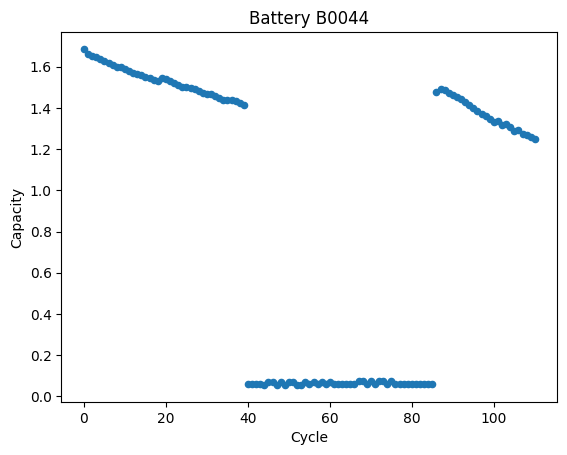

                Capacity
3513   1.001982588175331
3517  1.8011007566288924
3519  1.8044229856020628
3521   1.804388833772829
3523  1.7989248871784247
...                  ...
3987   1.596985400389019
3989   1.595726023703856
3991   1.579500338340559
3993  1.5629469877520186
3995  1.5591129431541175

[197 rows x 1 columns]
3513     1.001982588175331
3517    1.8011007566288924
3519    1.8044229856020628
3521     1.804388833772829
3523    1.7989248871784247
               ...        
3987     1.596985400389019
3989     1.595726023703856
3991     1.579500338340559
3993    1.5629469877520186
3995    1.5591129431541175
Name: Capacity, Length: 197, dtype: object


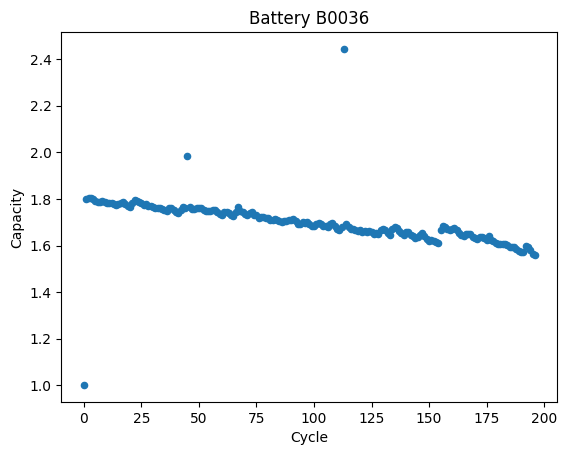

                Capacity
4002   1.847011162956716
4004  1.8485654344528386
4006   1.847111177186175
4008  1.8489837601535537
4010  1.8370120718560439
4014   1.817549211247137
4018   1.839863822522073
4021  1.8430595619731431
4023  1.8401871729536057
4025  1.8281265632888257
4029  1.8253563336445804
4033  1.8214180552626154
4035   1.830315627968932
4037  1.8175491643824844
4039   1.810901200296979
4041  1.8083032603084233
4045  1.7928016149381065
4049   1.812563150045885
4051   1.807772607491239
4053  1.8048055175003972
4055   1.800538555899242
4057  1.7942356098033032
4064   1.807409052434889
4066  1.7902504816962075
4068  1.7961223845359495
4070  1.7912236690350776
4072  1.7854822365303245
4076  1.7677890780323617
4002     1.847011162956716
4004    1.8485654344528386
4006     1.847111177186175
4008    1.8489837601535537
4010    1.8370120718560439
4014     1.817549211247137
4018     1.839863822522073
4021    1.8430595619731431
4023    1.8401871729536057
4025    1.8281265632888257
4029 

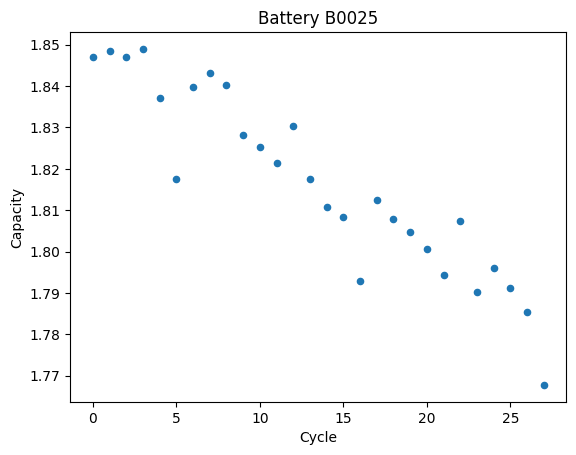

                Capacity
4082  1.8132504303869899
4084  1.8149760087078302
4086  1.8135354175561993
4088   1.815149273310334
4090  1.8142913014068198
4094  1.3863373424430125
4098  1.8165277958816064
4101  1.8085638576011063
4103   1.804936077644182
4105  1.8049315924982108
4109   1.717679232699393
4113   1.809804813280106
4115   1.806556213274488
4117  1.7938155707698507
4119   1.799304949381792
4121  1.7842197448470132
4125  1.6818819918515189
4129  1.8007519383961936
4131   1.795972684272296
4133  1.7931026940553298
4135  1.8010267542068712
4137  1.7824572301269948
4144  1.7959303030608789
4146  1.7783142127341003
4148   1.771719092984802
4150  1.7790749489536772
4152  1.7733229782464675
4156   1.768754111010884
4082    1.8132504303869899
4084    1.8149760087078302
4086    1.8135354175561993
4088     1.815149273310334
4090    1.8142913014068198
4094    1.3863373424430125
4098    1.8165277958816064
4101    1.8085638576011063
4103     1.804936077644182
4105    1.8049315924982108
4109 

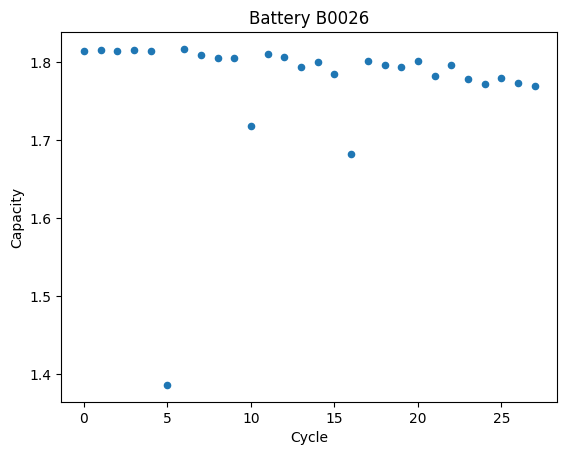

                Capacity
4160  1.6666751942525773
4162  1.8328583629543174
4164  1.8139835002945137
4166  1.8044387333514835
4168   1.802147684291295
4172  1.7715647509798835
4174  1.8139928165779542
4176  1.8013261041198854
4178  1.7883722583933568
4180  1.7765401657373159
4184  1.7856209131823229
4186  1.7813634036685941
4188  1.7684898383971241
4190   1.766505238291406
4192   1.751740527921767
4196  1.7352349314055016
4198  1.7782778274549178
4200  1.7649894859707393
4202   1.762591283533551
4204   1.744314576121582
4208  1.7628373753518478
4210   1.747857930947971
4212  1.7441167338864993
4214  1.7268422932817387
4216  1.7203093493042265
4220  1.7394245516699778
4222  1.7367384416372014
4224   1.716963468448543
4226  1.7127773558366357
4228  1.7061083466554066
4232   1.713732696207521
4234  1.7093475797926974
4236  1.6901000454115587
4238  1.6946883343387664
4240   1.687010991299212
4244  1.6957069027070075
4246   1.687696889615565
4248  1.6819617127259294
4250  1.6750033888978846


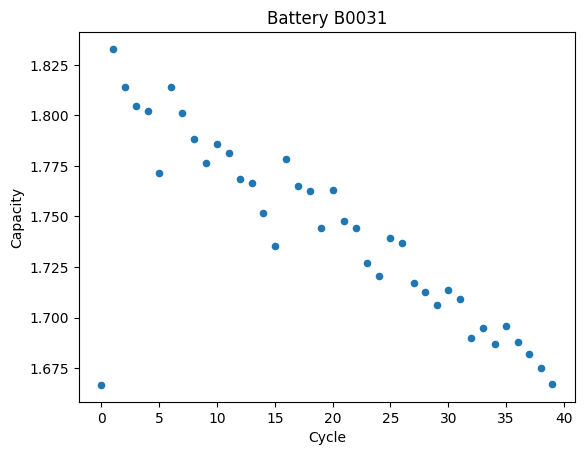

                Capacity
4256  0.8583727215167135
4260  1.4209057149417375
4262   1.372852133389263
4264  1.3643742487429145
4266   2.378643730568756
4270  1.0605357965671216
4272  1.0069932376659496
4274  0.9298775334359536
4276  0.9232377029483808
4278  0.9053279121173716
4282  0.8595848360639872
4284  0.8369614294820705
4286  0.8456824187653132
4288  0.8071214007577537
4290  0.7820744360746734
4294  0.7953019444133349
4296                   0
4298  0.7752051154719997
4300  0.7711865903845158
4302  0.7585098914517947
4306  0.7349386490499009
4308  0.7366758033690756
4310  0.7093946599203638
4312  0.7186465009220309
4314  0.6913885231046639
4256    0.8583727215167135
4260    1.4209057149417375
4262     1.372852133389263
4264    1.3643742487429145
4266     2.378643730568756
4270    1.0605357965671216
4272    1.0069932376659496
4274    0.9298775334359536
4276    0.9232377029483808
4278    0.9053279121173716
4282    0.8595848360639872
4284    0.8369614294820705
4286    0.8456824187653132

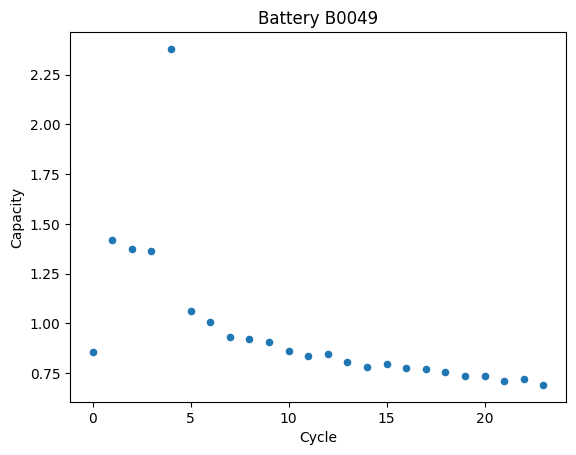

                 Capacity
4318   0.8631448527758341
4322    1.648789607776492
4324    1.601636485397804
4326   1.5517564797427017
4328  0.03255841710834194
4332   2.6401491157387014
4334    1.359027658891632
4336   1.3742172692238257
4338   1.3528030430821978
4340   1.3607406193458433
4344   0.5268786924650971
4346   1.4002714246164416
4348   1.4289274755270827
4350  0.07658354174014805
4352   0.5736933387569048
4356   0.3014742035427856
4358                    0
4360  0.17956542632321462
4362    1.179168781562907
4364   0.0961913170505672
4368  0.27808517709104497
4370                   []
4372                   []
4374                   []
4376                   []
4318     0.8631448527758341
4322      1.648789607776492
4324      1.601636485397804
4326     1.5517564797427017
4328    0.03255841710834194
4332     2.6401491157387014
4334      1.359027658891632
4336     1.3742172692238257
4338     1.3528030430821978
4340     1.3607406193458433
4344     0.5268786924650971
4346     1.40027

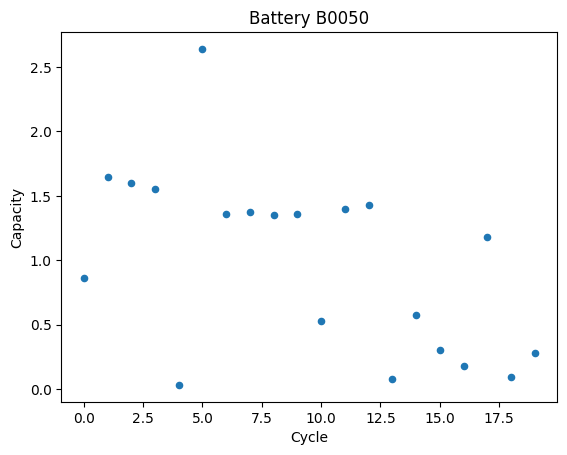

                Capacity
4380  0.8606591508342232
4384  1.4183095114360322
4386  1.3707123028693164
4388  1.3515647352626494
4390                  []
4394                  []
4396                  []
4398                  []
4400                  []
4402                  []
4406                  []
4408                  []
4410                  []
4412                  []
4414                  []
4418                  []
4420                  []
4422                  []
4424                  []
4426                  []
4430                  []
4432                  []
4434                  []
4436                  []
4438                  []
4380    0.8606591508342232
4384    1.4183095114360322
4386    1.3707123028693164
4388    1.3515647352626494
4390                    []
4394                    []
4396                    []
4398                    []
4400                    []
4402                    []
4406                    []
4408                    []
4410                    []

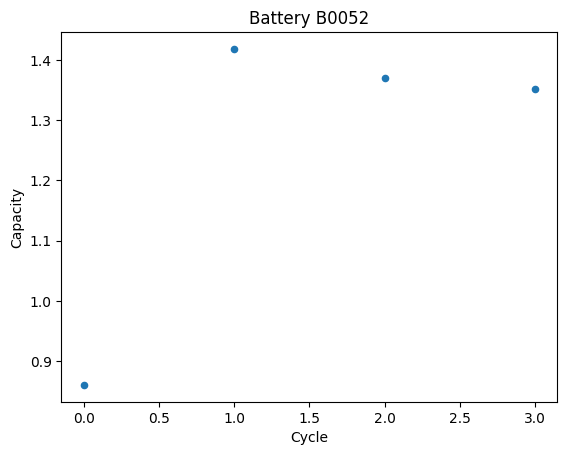

                Capacity
4442  0.6434735598158292
4446  1.2931804619982779
4448  1.2288940261191657
4450  1.2039031789717949
4452   2.330873478782131
4456  1.0092808819126011
4458  0.9565659895125322
4460   0.901956291365404
4462  0.8897906666138162
4464  0.8830717036634559
4468  0.8431270354481757
4470   0.826559103449663
4472  0.8352681546837963
4474  0.8025719464987874
4476  0.7839218784699513
4480  0.7910763493036002
4482                   0
4484  0.7654538269480236
4486   0.773177347633947
4488  0.7605293776416485
4492  0.7376430319247004
4494   0.739179500257907
4496  0.7014575429842594
4498  0.7047349480541781
4500   0.677848893570423
4442    0.6434735598158292
4446    1.2931804619982779
4448    1.2288940261191657
4450    1.2039031789717949
4452     2.330873478782131
4456    1.0092808819126011
4458    0.9565659895125322
4460     0.901956291365404
4462    0.8897906666138162
4464    0.8830717036634559
4468    0.8431270354481757
4470     0.826559103449663
4472    0.8352681546837963

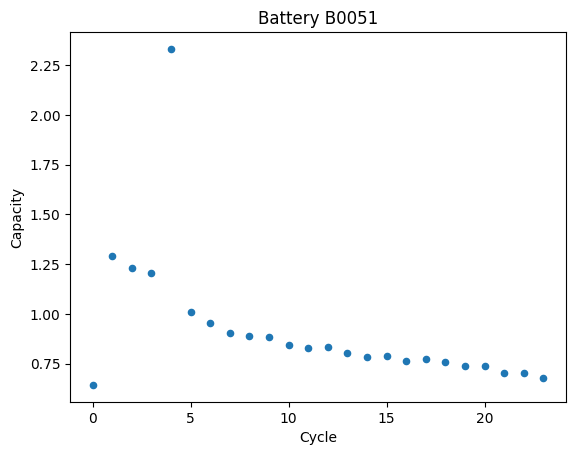

                Capacity
4505   2.035337591005598
4507  2.0251402460314116
4509   2.013326371345464
4511  2.0132846655407413
4513   2.000528337624771
...                  ...
5103    1.15381833159625
5107  1.1644009557372264
5111  1.1587974947916069
5115  1.1749748834769171
5117  1.1856752327929356

[168 rows x 1 columns]
4505     2.035337591005598
4507    2.0251402460314116
4509     2.013326371345464
4511    2.0132846655407413
4513     2.000528337624771
               ...        
5103      1.15381833159625
5107    1.1644009557372264
5111    1.1587974947916069
5115    1.1749748834769171
5117    1.1856752327929356
Name: Capacity, Length: 168, dtype: object


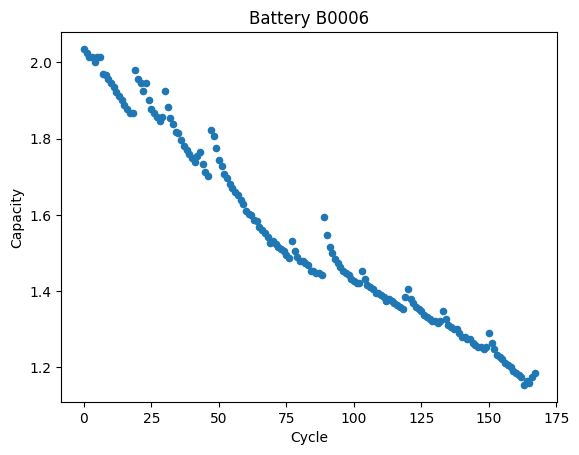

                Capacity
5121  1.8564874208181574
5123   1.846327249719927
5125  1.8353491942234077
5127  1.8352625275821128
5129  1.8346455082120419
...                  ...
5719   1.293463613844243
5723   1.288003392619118
5727  1.2874525221379407
5731  1.3090153642307354
5733  1.3250793286429356

[168 rows x 1 columns]
5121    1.8564874208181574
5123     1.846327249719927
5125    1.8353491942234077
5127    1.8352625275821128
5129    1.8346455082120419
               ...        
5719     1.293463613844243
5723     1.288003392619118
5727    1.2874525221379407
5731    1.3090153642307354
5733    1.3250793286429356
Name: Capacity, Length: 168, dtype: object


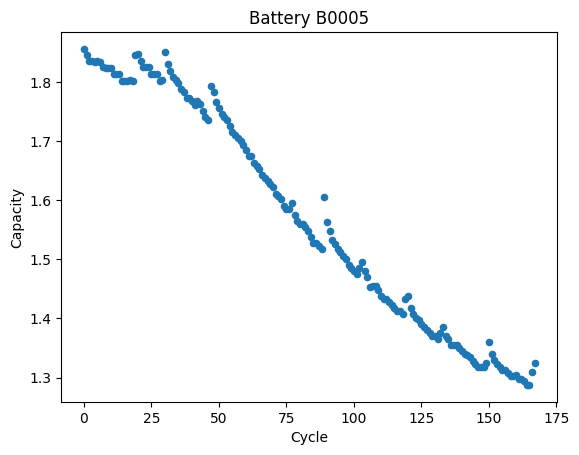

                Capacity
5737    1.89105229539079
5739   1.880637027686859
5741  1.8806626717011388
5743  1.8807709009833444
5745  1.8794508728285058
...                  ...
6335  1.4061714290398801
6339  1.4063358479692922
6343  1.4004552399066514
6347  1.4217865046055154
6349  1.4324552720625434

[168 rows x 1 columns]
5737      1.89105229539079
5739     1.880637027686859
5741    1.8806626717011388
5743    1.8807709009833444
5745    1.8794508728285058
               ...        
6335    1.4061714290398801
6339    1.4063358479692922
6343    1.4004552399066514
6347    1.4217865046055154
6349    1.4324552720625434
Name: Capacity, Length: 168, dtype: object


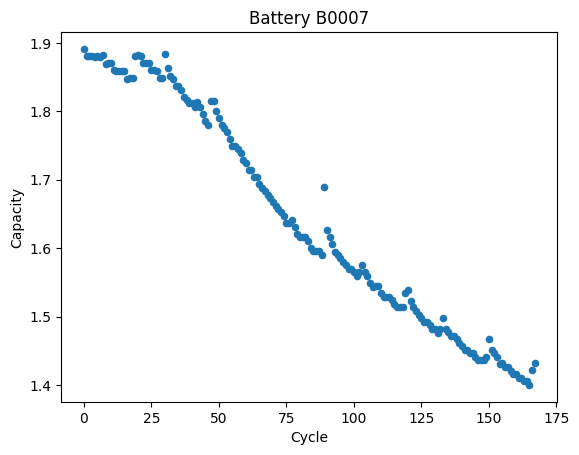

                Capacity
6354  1.8550045207910817
6358  1.8431955317089987
6362  1.8396018424355423
6366  1.8306736044962053
6369  1.8327002069419656
...                  ...
6660  1.3627371779096438
6662  1.3634051133928073
6665  1.3518646035305233
6668  1.3547969729652622
6670   1.341051440640485

[132 rows x 1 columns]
6354    1.8550045207910817
6358    1.8431955317089987
6362    1.8396018424355423
6366    1.8306736044962053
6369    1.8327002069419656
               ...        
6660    1.3627371779096438
6662    1.3634051133928073
6665    1.3518646035305233
6668    1.3547969729652622
6670     1.341051440640485
Name: Capacity, Length: 132, dtype: object


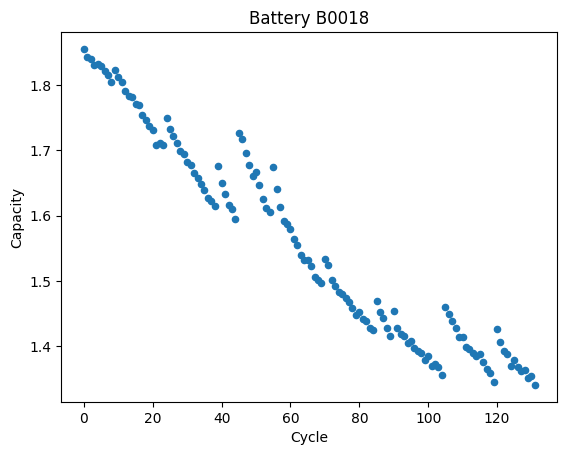

                Capacity
6671  1.0691417886194299
6675  1.1540727934432229
6677  1.1501525413826983
6679  1.1305863853936766
6681   1.121790272357562
6683  1.1135982401443856
6687  1.0864654057095062
6689  1.0647493568993147
6691  1.0809288094959644
6693  1.0852752041846463
6695  1.0504799933740894
6699  1.0853550177054305
6701  1.0508395690790722
6703   1.060906788333118
6705   1.070582461063814
6707   1.024036665663697
6711  1.0670957253433857
6713  1.0279237850447498
6715  1.0325426399701008
6717   1.055948784653705
6719  1.0445313831308718
6723   1.035313906812183
6727   1.076341053101982
6729  1.0352223140423542
6731  1.0514287056908256
6733   1.060332934638968
6735  1.0236966462748538
6739  1.0465884668750887
6741  1.0031121684812232
6743  1.0461578935615607
6745  1.0156263513525605
6747  1.0250054893129452
6751  0.9801331625592913
6753   1.036777776420363
6755   1.026830062058722
6757  1.0150379662805102
6759  0.9904614739486177
6763  1.0145765174582757
6765  0.9811308944080389


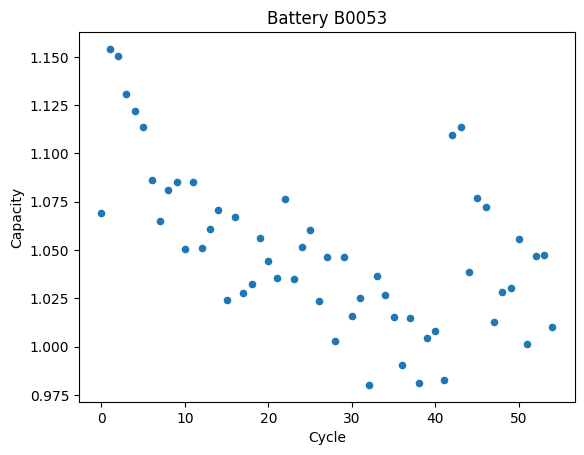

                Capacity
6808  0.7399351039859233
6812  1.1665440238116096
6814  1.1052521456138635
6816  1.0960302257185877
6818  1.0754450685609742
...                  ...
7050  0.8440520909609104
7052  0.8536244678403578
7056  0.8524519337958137
7058  0.8373919001793014
7060                   0

[103 rows x 1 columns]
6808    0.7399351039859233
6812    1.1665440238116096
6814    1.1052521456138635
6816    1.0960302257185877
6818    1.0754450685609742
               ...        
7050    0.8440520909609104
7052    0.8536244678403578
7056    0.8524519337958137
7058    0.8373919001793014
7060                     0
Name: Capacity, Length: 103, dtype: object


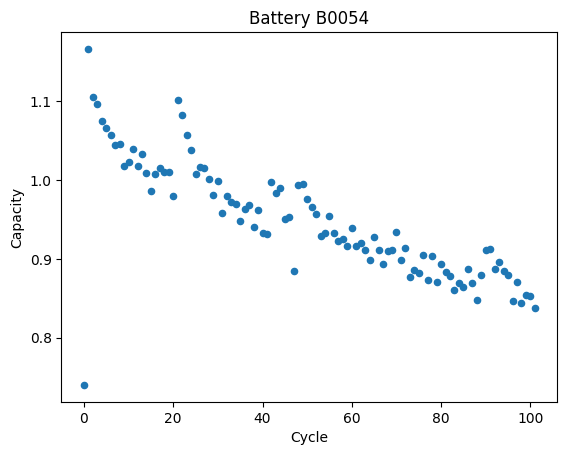

                Capacity
7061  0.7852781208785192
7065  1.3443555553017368
7067   1.317502710734752
7069  1.2973654679476911
7071   1.263960414854898
...                  ...
7301  1.1302191455340138
7303  1.1258719408034097
7305  1.1430108283920968
7309  1.1372731775310292
7311  1.1290590137779504

[102 rows x 1 columns]
7061    0.7852781208785192
7065    1.3443555553017368
7067     1.317502710734752
7069    1.2973654679476911
7071     1.263960414854898
               ...        
7301    1.1302191455340138
7303    1.1258719408034097
7305    1.1430108283920968
7309    1.1372731775310292
7311    1.1290590137779504
Name: Capacity, Length: 102, dtype: object


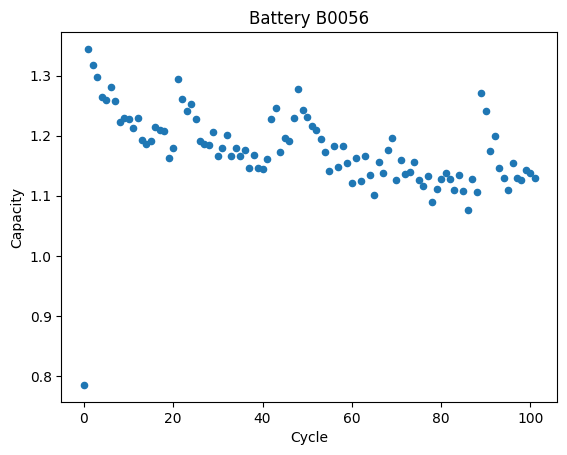

                Capacity
7313  0.7989997927037011
7317   1.319892156462878
7319  1.2769832801132017
7321  1.2572591312230865
7323   1.206763751299412
...                  ...
7553  1.0285269676595319
7555  0.9816844358987022
7557  1.0127121434171131
7561  1.0201379996149256
7563  0.9907591663373165

[102 rows x 1 columns]
7313    0.7989997927037011
7317     1.319892156462878
7319    1.2769832801132017
7321    1.2572591312230865
7323     1.206763751299412
               ...        
7553    1.0285269676595319
7555    0.9816844358987022
7557    1.0127121434171131
7561    1.0201379996149256
7563    0.9907591663373165
Name: Capacity, Length: 102, dtype: object


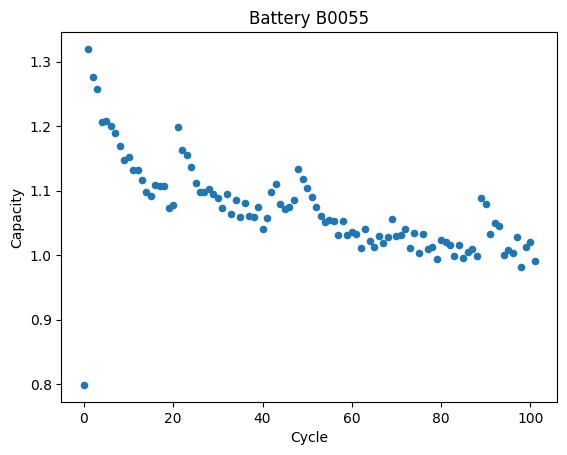

In [ ]:
batt_ids = df['battery_id'].unique()

def try_float(x):
    try:
        return float(x)
    except:
        return 0


for batt_id in batt_ids:
    # Put non-null Capacity values of battery with battery_id B0047 into a dataframe
    df_batt = df[df['battery_id'] == batt_id]
    df_batt = pd.DataFrame(df_batt[df_batt['Capacity'].notnull()]['Capacity'])

    if (df_batt.empty):
        continue

    # Go through and transform all 'Capacity' values to float
    df_batt['Capacity'] = df_batt['Capacity'].apply(try_float)

    # Drop all rows with 'Capacity' values that are 0
    df_batt = df_batt[df_batt['Capacity'] != 0]

    # Reset index
    df_batt.reset_index(drop=True, inplace=True)

    # Add 'Cycle' column starting from 0
    df_batt['Cycle'] = np.arange(len(df_batt))

    df_batt.plot.scatter(x='Cycle', y='Capacity')
    plt.title('Battery ' + batt_id)
    plt.show()